In [1]:
#Import packages
import glob
import numpy as np
import sklearn
import pandas as pd
from pandas import Series, DataFrame
from marketools import Stock

import matplotlib.pyplot as plt
import seaborn as sns # data visualization library
from time import time
import sys
import csv
import os
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
import h5py as h5
# Interpolation stuff so we can get equilibrium bond distances
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy import stats
#######################################################
from sklearn import linear_model
from sklearn import metrics, svm
from sklearn import preprocessing



# Feature selection
from sklearn import feature_selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA





# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


<ipython-input-1-b15c18a80f3b>:15: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)


In [12]:
# https://github.com/AlbertRtk/marketools
fcel = Stock('TSLA')

In [21]:
dir(fcel)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fundamentals',
 '_ohlc',
 'date',
 'dividend_yield',
 'eps',
 'fundamentals',
 'last_ohlc',
 'mean_volume',
 'ohlc',
 'pbv',
 'pe',
 'price',
 'stooq_plot_link',
 'ticker',
 'volume']

In [2]:
# Switch from current dir to the MLDataGrab dir
datadir =os.getcwd()
files=sorted(glob.glob(os.path.join(datadir,'*.csv')))
ATHX=files[0]
GE=files[1]
ATHX_df=pd.read_csv(ATHX)
GE_df=pd.read_csv(GE)

In [3]:
# Create a new column for daily percent change 
# ((Close-Open)/Open)*100%
GE_percent=((GE_df['Close']-GE_df['Open'])/GE_df['Close'])*100
GE_df['Percent Change']=GE_percent

ATHX_percent=((ATHX_df['Close']-ATHX_df['Open'])/ATHX_df['Close'])*100
ATHX_df['Percent Change']=ATHX_percent

In [4]:
GE_df.describe()

Open        High         Low       Close   Adj Close  \
count  252.000000  252.000000  252.000000  252.000000  252.000000   
mean     9.605437    9.762976    9.436667    9.597024    9.579852   
std      1.900291    1.888486    1.928004    1.911454    1.906026   
min      5.610000    5.660000    5.480000    5.490000    5.490000   
25%      8.355000    8.515000    8.155000    8.272500    8.254584   
50%      9.925000   10.085000    9.820000    9.980000    9.955488   
75%     11.112500   11.202500   10.985000   11.115000   11.093915   
max     13.080000   13.260000   12.900000   13.160000   13.146944   

             Volume  Percent Change  
count  2.520000e+02      252.000000  
mean   7.369260e+07       -0.154169  
std    4.640395e+07        2.404859  
min    2.076900e+07       -9.388336  
25%    4.393748e+07       -1.457953  
50%    5.998030e+07        0.000000  
75%    9.372392e+07        1.269185  
max    4.010487e+08        8.547794

In [5]:
plt.plot(range(len(np.array(GE_df['Close']))),np.array(GE_df['Close']),label='GE Close')
plt.plot(range(len(np.array(ATHX_df['Close']))),np.array(ATHX_df['Close']),label='ATHX Close')
plt.legend(loc=3,fontsize = 12)
# plt.ylim(-6, 6)
plt.title(r'Stock Closing Price',fontsize=14)
plt.xlabel(r'Date',fontsize=14)
plt.ylabel(r'Price ($)',fontsize=14)


plt.tight_layout()
plt.show()

In [6]:
correlations = GE_df.corr()

fig, ax = plt.subplots(figsize=(len(np.transpose(GE_df)),len(np.transpose(GE_df))))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=0.5, annot=True, cbar_kws={"shrink": .70})
plt.tight_layout();
plt.plot(rasterized=True)
#     plt.savefig('./'+str(filename)+'.png', format='png');
plt.show()

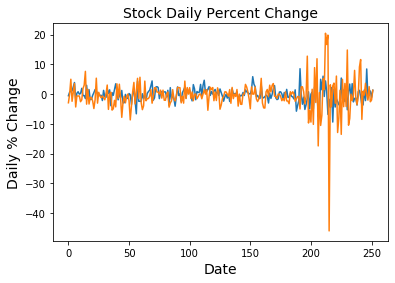

In [7]:
plt.plot(range(len(np.array(GE_df['Percent Change']))),np.array(GE_df['Percent Change']))
plt.plot(range(len(np.array(ATHX_df['Percent Change']))),np.array(ATHX_df['Percent Change']))
plt.title(r'Stock Daily Percent Change',fontsize=14)
plt.xlabel(r'Date',fontsize=14)
plt.ylabel(r'Daily % Change',fontsize=14)
plt.show()

In [8]:
X=GE_df.drop(columns='Close').drop(columns='Date')
y=GE_df['Close']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.3)

# print(X_train,X_test)
# Grab indexing labels, this will help out later
testPoints=y_test.axes[0].tolist()
TrainPoints=y_train.axes[0].tolist()



#
# Scale all data before using them as features
#
# MinMaxScaler      
scaler = MinMaxScaler().fit(X_train)  
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
regressor =linear_model.Ridge()
parameters={"alpha": [1e0,0.1, 1e-2, 1e-3,1e-4],
        "tol": np.logspace(-4, 0, 5)}
GridSearch = GridSearchCV(regressor, param_grid=parameters, cv=6, verbose=1)
GridSearch.fit(X_train_scaled,y_train.values.ravel())
print('Best score %0.4f'%GridSearch.best_score_)
print('Best parameters:',GridSearch.best_params_)
reg8=linear_model.Ridge(**GridSearch.best_params_)

t0 = time()    
model=reg8.fit(X_train_scaled,y_train)
print("Model fit in %0.5fs" % (time() - t0))
t1 = time() 
y_train_pred=model.predict(X_train_scaled)
print("Prediction on Training set in %0.5fs" % (time() - t1))

t2 = time() 
y_test_pred=model.predict(X_test_scaled)
print("Prediction on Test set in %0.5fs" % (time() - t2))

#     print('Train MAE: %.8E' % mean_absolute_error(y_train,y_train_pred),'Eh')
#     print('Train RMSE: %.8E' % np.sqrt(mean_squared_error(y_train,y_train_pred)),'Eh','\n')


print('Test MAE: %.8E' % mean_absolute_error(y_test.values.ravel(),y_test_pred),'Eh')
print('Test RMSE: %.8E' % np.sqrt(mean_squared_error(y_test.values.ravel(),y_test_pred)),'Eh','\n')
print(' Test set R^2: %.5f'%model.score(X_test_scaled,y_test),' Train set R^2: %.5f'%model.score(X_train_scaled,y_train))
print("Total time %0.5fs" % (time() - t0))
testPoints=np.array(testPoints)
TrainPoints=np.array(TrainPoints)
y_test=np.array(y_test)
y_train=np.array(y_train)




print('\n')
# print(X_train_scaled.shape,X_test.shape,X_test_scaled.shape,y_train.shape, y_test.shape)

Fitting 6 folds for each of 25 candidates, totalling 150 fits
Best score 1.0000
Best parameters: {'alpha': 0.0001, 'tol': 0.0001}
Model fit in 0.00058s
Prediction on Training set in 0.00031s
Prediction on Test set in 0.00029s
Test MAE: 7.94831567E-03 Eh
Test RMSE: 9.73411221E-03 Eh 

 Test set R^2: 0.99997  Train set R^2: 0.99997
Total time 0.00761s




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


In [36]:
# pd.DataFrame({'testPoints':testPoints,'y_test_pred':y_test_pred}).sort_values(by='testPoints')

In [37]:
# pd.DataFrame({'testPoints':testPoints,'y_test':y_test}).sort_values(by='testPoints')['testPoints']

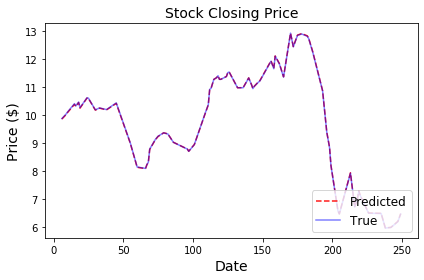

In [35]:
plt.plot(pd.DataFrame({'testPoints':testPoints,'y_test_pred':y_test_pred}).sort_values(by='testPoints')['testPoints'],pd.DataFrame({'testPoints':testPoints,'y_test_pred':y_test_pred}).sort_values(by='testPoints')['y_test_pred'],ls='--',alpha=0.9,label="Predicted",color='red')
plt.plot(pd.DataFrame({'testPoints':testPoints,'y_test':y_test}).sort_values(by='testPoints')['testPoints'],pd.DataFrame({'testPoints':testPoints,'y_test':y_test}).sort_values(by='testPoints')['y_test'],label="True",color='blue',alpha=0.5)
plt.legend(loc=4,fontsize = 12)
# plt.ylim(-6, 6)
plt.title(r'Stock Closing Price',fontsize=14)
plt.xlabel(r'Date',fontsize=14)
plt.ylabel(r'Price ($)',fontsize=14)
plt.tight_layout()
plt.show()